# Introduction

This notebook contains the numerical methods used in arXiv:XXXX.XXXXX. We illustrate with examples how to use the methods and reproduce the results shown in the paper

The notebook is organized as follows
- In **Step 0** we import the packages and define the functions we need
- In **Step 1** we do a case study of finding a GPT model with a specific rank $k$ fit for some given frequency table (see Section II. B. of arXiv)
- In **Step 2** we iterate **Step 1** for several distinct ranks $k \in\{2,3,\ldots,9\}$ in order to estimate which rank $k$ provides the best fit (see Section II. C. of arXiv)
- In **Step 3** we take the GPT model for rank $k=4$ and use the QR decomposition to normalize the state and effect spaces
- In **Step 4** we obtain the *consistent* sets out of computing the dual spaces of the found state and effect *realized* spaces
- In **Step 5** we find a transformation that brings the *states consistent* space as close to the unit sphere as possible. Then we use the found transformation on different state realized spaces to compare them
- In **Step 6** we compute the volume of the found state spaces for different time evolutions, to see how it varies as the qubit decoheres

# Step 0: Import packages and define the main functions to be used

In [1]:
# First import the main packages we need

import cvxopt  as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import scipy as sp

# Extra packages necessary for steps 4 and beyond
import cdd # https://pycddlib.readthedocs.io/en/latest/polyhedron.html (on windows we had to downgrade the python version to (e.g.) 3.9 to install this package)
from fractions import Fraction
import scipy.linalg
import scipy.optimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import linprog

## Define the functions for the simplex embedding to find a GPT model fit

In [2]:
# These functions are to generate the arrays used as constraints in the linear program
def create_array(n):
    arr = np.zeros(n)  # Create an array of zeros with n elements
    arr[0] = 1  # Set the first element to 1
    return arr

def Barray(n,cardinality):
    array = np.zeros((cardinality, n*cardinality))
    for i in range(cardinality):
            array[i,n*i] = 1 
    return array

def Aarray(n,cardinality):
    array = np.hstack((np.eye(cardinality),np.zeros((cardinality,(n-1)*cardinality))))
    return array

Next we define the functions used to pose+solve the conic problems that allow us to find the fit model:

In [3]:
# The objective function in the linear program (c.f., Eq. 4)
def chisquared(quintuple, data):
    return np.sum(np.multiply(np.power((np.dot(quintuple[0],quintuple[1]) - data), 2), oneoverW))

In [4]:
# the linear program used to obtain the state space that minimizes chi_squared for rank n while the effects are given and fixed
def state_optim(eff, data, n):
    # here n is the rank  
    data_dimensions = data.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number of preparations
    cardinality_effects = data_dimensions[1] # number of measurements
    cardinality = cardinality_preparations #it assumes num preps = num measurements, otherwise the dimensions need to be adapted    
    Im = np.identity(cardinality_preparations) # identity matrix
    Wprime = np.diag(oneoverW.flatten(('F')))
    Pfunc = cv.matrix(2*np.dot(np.dot(np.kron(eff,Im),Wprime),np.transpose(np.kron(eff,Im))))
    qfunc = cv.matrix(-2*np.dot(np.dot(np.kron(eff,Im),Wprime),data.flatten(('F'))))
    hfunc = cv.matrix(np.array([np.ones(cardinality_preparations*cardinality_effects),np.zeros(cardinality_preparations*cardinality_effects)]).reshape(2*cardinality_preparations*cardinality_effects,1))
    Gfunc = cv.matrix(np.kron(np.array([[1],[-1]]),np.transpose(np.kron(eff,Im))))
    Afunc = cv.matrix(Aarray(n,cardinality_preparations))
    bfunc = cv.matrix(np.ones([cardinality_preparations,1]))
    cv.solvers.options['show_progress'] = False # to silence CVX's progress    
    solfunc = cv.solvers.qp(Pfunc,qfunc,Gfunc,hfunc,Afunc,bfunc)
    return np.array(solfunc['x']).reshape(n,cardinality_preparations).T

# the linear program used to obtain the effect space that minimizes chi_squared for rank n while the states are given and fixed
def effect_optim_NOAB(state, data, n):
    # here n is the rank 
    data_dimensions = data.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number of preparations
    cardinality_effects = data_dimensions[1] # number of measurements  
    cardinality = cardinality_preparations #it assumes num preps = num measurements, otherwise the dimensions need to be adapted 
    Im = np.identity(cardinality_effects) # identity matrix
    Wprime = np.diag(oneoverW.flatten(('F')))
    Pefffunc = cv.matrix(2*np.dot(np.dot(np.transpose(np.kron(Im,state)),Wprime), np.kron(Im,state)))
    qefffunc = cv.matrix(-2*np.dot(np.dot(np.transpose(np.kron(Im,state)),Wprime), data.flatten(('F'))))
    Gefffunc = cv.matrix(np.kron(np.array([[1],[-1]]),np.kron(Im,state)))
    hefffunc = cv.matrix(np.array([np.ones(cardinality_preparations*cardinality_effects),np.zeros(cardinality_preparations*cardinality_effects)]).reshape(2*cardinality_preparations*cardinality_effects,1))
    cv.solvers.options['show_progress'] = False # to silence CVX's progress
    solefffunc = cv.solvers.qp(Pefffunc,qefffunc,Gefffunc,hefffunc)
    return np.array(solefffunc['x']).reshape(cardinality_effects,n).T
    
# here we iterate between minimizing chi_squared over states or over effects to keep updating 
# the states/effects spaces until the improvement of the new chi_squared is smaller than our convergence threshold 
def seesaw_optim(func_state_optim, func_effect_optim, quintuple, convergence_tolerance):
    # quintuple = [states, effects, prob, data, rank]    
    """
    func_state_optim and func_effect_optim are the different conic problems (depending on which constraints are inputed and such)
    For example one can call:
        state_optim
        state_optim_NOAB
        state_optim_noW_no_AB
    """
    datamat = quintuple[3] # get data
    data_dimensions = datamat.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number preparations    
    current_states = quintuple[0] # grab the initial states
    rank = quintuple[4] # get rank    
    if np.all(current_states) == 0: # for when no states have inputed 
        np.random.rand(cardinality_preparations,rank) # initialize to random States
    previous_chisquared = 1e10 # initialize error to some crazy high value
    exitCriteria = 0 # initialize to "not converged"
    maxIterations = 300 # how many tries before calling it a day (even if it didn't converge)
    attempts = 0
    while exitCriteria < 1: # convergence criteria
            current_effects = func_effect_optim(current_states, datamat, rank)
            current_states = func_state_optim(current_effects, datamat, rank)
            prob = np.dot(current_states, current_effects) 
            # convergence check. we assume convergence when the progress finding chi^2 is smaller than convergence_tolerance
            current_chisquared = chisquared([current_states, current_effects, prob, datamat, rank], datamat)
            print("Rank = " + str(rank) + ", iteration = " + str(attempts + 1) + ". Current Chi^2 = " + str(current_chisquared))
            if  previous_chisquared - current_chisquared < convergence_tolerance or attempts == maxIterations:
                print("Rank = " + str(rank) + ", iteration = " + str(attempts + 1) + ". Converged to Chi^2 = " + str(current_chisquared))
                exitCriteria = 1
            else:
                attempts = attempts + 1
                previous_chisquared = current_chisquared
    prob = np.dot(current_states, current_effects) # get the probability table for the found states and effects
    return [current_states, current_effects, prob, quintuple[3], quintuple[4], current_chisquared]

# Here we call seesaw_optim for several different ranks n
def seesaw_over_range(func_state_optim, func_effect_optim, datamat, first_rank, final_rank, convergence_tolerance):
    # from first_rank to final_rank (both inclusive)
    data_dimensions = datamat.shape # get the frequency matrix dimensions
    cardinality_preparations = data_dimensions[0]    
    cardinality_effects = data_dimensions[1]
    return [seesaw_optim(func_state_optim, func_effect_optim, [np.random.rand(cardinality_preparations, rank), 0, 0, datamat, rank], convergence_tolerance) for rank in range(first_rank, final_rank+1, 1)]

## (Optional) Other ways to solve the optimization problem given different constraints

Although not used in our paper, for completion we include in the next cell functions which are mild modifications of the linear programs in the previous cell. The main different is the constraints involved in the conic optimization problem:

In [12]:
# (optional)

def effect_optim(state, data, n):
    # n is the rank  
    data_dimensions = data.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number of preparations
    cardinality_effects = data_dimensions[1] # number of measurements
    cardinality = cardinality_preparations #it assumes num preps = num measurements, otherwise the dimensions need to be adapted    
    Im = np.identity(cardinality_effects) # identity matrix
    Wprime = np.diag(oneoverW.flatten(('F')))
    Pefffunc = cv.matrix(2* np.dot(np.dot(np.transpose(np.kron(Im,state)),Wprime), np.kron(Im,state)))
    qefffunc = cv.matrix(-2*np.dot(np.dot(np.transpose(np.kron(Im,state)),Wprime), data.flatten(('F'))))
    Gefffunc = cv.matrix(np.kron(np.array([[1],[-1]]),np.kron(Im,state)))
    hefffunc = cv.matrix(np.array([np.ones(cardinality_preparations*cardinality_effects),np.zeros(cardinality_preparations*cardinality_effects)]).reshape(2*cardinality_preparations*cardinality_effects,1))
    Aefffunc = cv.matrix(Barray(n,cardinality_effects))
    befffunc = cv.matrix(0.5 * np.ones([cardinality_effects,1]))
    cv.solvers.options['show_progress'] = False # to silence CVX's progress    
    solefffunc = cv.solvers.qp(Pefffunc,qefffunc,Gefffunc,hefffunc,Aefffunc,befffunc)
    return np.array(solefffunc['x']).reshape(cardinality_effects,n).T

def state_optim_NOAB(eff, data, n):
    # n is the rank  
    data_dimensions = data.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number of preparations
    cardinality_effects = data_dimensions[1] # number of measurements
    cardinality = cardinality_preparations #it assumes num preps = num measurements, otherwise the dimensions need to be adapted
    Im = np.identity(cardinality_preparations) # identity matrix
    Wprime = np.diag(oneoverW.flatten(('F'))) # 'F' means to flatten in Column major. 'C' for row
    # Wprime is a diagonal mn x mn matrix, encoding the uncertainties 1/(\Delta F_ij)^2 in the diagonal entries
    Pfunc = cv.matrix(2*np.dot(np.dot(np.kron(eff,Im),Wprime),np.transpose(np.kron(eff,Im))))
    qfunc = cv.matrix(-2*np.dot(np.dot(np.kron(eff,Im),Wprime),data.flatten(('F'))))
    hfunc = cv.matrix(np.array([np.ones(cardinality_preparations*cardinality_effects),np.zeros(cardinality_preparations*cardinality_effects)]).reshape(2*cardinality_preparations*cardinality_effects,1))
    Gfunc = cv.matrix(np.kron(np.array([[1],[-1]]),np.transpose(np.kron(eff,Im))))
    cv.solvers.options['show_progress'] = False # to silence CVX's progress
    solfunc = cv.solvers.qp(Pfunc,qfunc,Gfunc,hfunc)
    return np.array(solfunc['x']).reshape(n,cardinality_preparations).T
    
def state_optim_noW_no_AB(eff,data,n):
    # n is the rank  
    data_dimensions = data.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number of preparations
    cardinality_effects = data_dimensions[1] # number of measurements
    cardinality = cardinality_preparations #it assumes num preps = num measurements, otherwise the dimensions need to be adapted     
    Im = np.identity(cardinality_preparations) # identity matrix
    Pfunc = cv.matrix(2*np.dot(np.kron(eff,Im), np.transpose(np.kron(eff,Im))))
    qfunc = cv.matrix(-2*np.dot(np.kron(eff,Im),data.flatten(('F'))))
    hfunc = cv.matrix(np.array([np.ones(cardinality_preparations*cardinality_effects),np.zeros(cardinality_preparations*cardinality_effects)]).reshape(2*cardinality_preparations*cardinality_effects,1))
    Gfunc = cv.matrix(np.kron(np.array([[1],[-1]]),np.transpose(np.kron(eff,Im))))
    cv.solvers.options['show_progress'] = False # to silence CVX's progress    
    solfunc = cv.solvers.qp(Pfunc,qfunc,Gfunc,hfunc)
    return np.array(solfunc['x']).reshape(n,cardinality_preparations).T

 
def effect_optim_noW_no_AB(state,data,n):
    # n is the rank  
    data_dimensions = data.shape # frequency matrix dimensions
    cardinality_preparations = data_dimensions[0] # number of preparations
    cardinality_effects = data_dimensions[1] # number of measurements
    cardinality = cardinality_preparations #it assumes num preps = num measurements, otherwise the dimensions need to be adapted        Im = np.identity(cardinality_effects) # identity matrix
    Im = np.identity(cardinality_effects) # identity matrix
    Pefffunc = cv.matrix(2* np.dot(np.transpose(np.kron(Im,state)), np.kron(Im,state)))
    qefffunc = cv.matrix(-2*np.dot(np.transpose(np.kron(Im,state)), data.flatten(('F'))))
    Gefffunc = cv.matrix(np.kron(np.array([[1],[-1]]),np.kron(Im,state)))
    hefffunc = cv.matrix(np.array([np.ones(cardinality_preparations*cardinality_effects),np.zeros(cardinality_preparations*cardinality_effects)]).reshape(2*cardinality_preparations*cardinality_effects,1))
    cv.solvers.options['show_progress'] = False # to silence CVX's progress    
    solefffunc = cv.solvers.qp(Pefffunc,qefffunc,Gefffunc,hefffunc)
    return np.array(solefffunc['x']).reshape(cardinality_effects,n).T

# Step 1: Obtain the states and effects to fit a GPT model with rank $k=4$ (illustrative example)

We are now ready to load and prepare the data on which to find a model fit:

In [8]:
# load the data sets
# This data is illustrative and should get updated with the paper data
datamat = np.genfromtxt('Data/zzzGPTrun1.csv', delimiter=",") # data for which we find a model
testmat = np.genfromtxt('Data/zzzGPTrun2.csv', delimiter=",") # data to test the fit model

# Get the number of preparations and measurements from the given data
matrix_dimensions = datamat.shape # data dimensions
cardinality_preparations = matrix_dimensions[0] # number of preparations
cardinality_effects = matrix_dimensions[1] # number of measurements

runs_number = 101 # how many runs were used to estimate each conditional probability in the given data. For now this needs to be manually set 
oneoverW = runs_number/np.multiply(datamat, 1-datamat) # 1/W := 1/(\Sum \Delta F_ij)^2 (c.f. eq. 4)
Im = np.identity(cardinality_preparations) # for when we do not want these constraints on S and E

# add a first column of ones to the data, to force state normalization when obtaining the decomposition. comment otherwise
datamat = np.hstack((np.ones((cardinality_effects,1)), datamat))
testmat = np.hstack((np.ones((testmat.shape[1],1)), testmat))
oneoverW = np.hstack((1e+07*np.ones((cardinality_effects,1)), oneoverW))

Here is an example on how to call the seesaw optimization to find a model fit for a specific rank $k$:

In [9]:
# Call the seesaw optimization with convergence criteria for a given rank
rank = 4 # the given rank
convergence_tolerance = 1e-02 # we assume convergence when the progress is smaller than convergence_tolerance
current_states = np.random.rand(cardinality_preparations, rank) # initialize to random States
current_states[:,0] = 1 # maybe not so random, let's make an initial guess that the first column are 1 (for the normalization that we want)
current_effects = np.random.rand(rank, cardinality_effects) # initialize to random Effects. check if the order is correct
prob = np.dot(current_states, current_effects) # get their probability table
quintuple = [current_states, current_effects, prob, datamat, rank]
numerical_result = seesaw_optim(state_optim, effect_optim_NOAB, quintuple, convergence_tolerance)

numerical_result

### the linear program results are stored in the variable 'numerical_result' as:
# numerical_result[0] returns the found states
# numerical_result[1] returns the found effects
# numerical_result[2] returns the given probability table for the initial given states and effects. It can be ignored
# numerical_result[3] returns the given data, i.e. the frequency table obtained in the experiment
# numerical_result[4] returns the given rank k for the fit
# numerical_result[5] returns the found chi_squared

Rank = 4, iteration = 1. Current Chi^2 = 23113.742845780605
Rank = 4, iteration = 2. Current Chi^2 = 498.3993457831026
Rank = 4, iteration = 3. Current Chi^2 = 497.76739715917233
Rank = 4, iteration = 4. Current Chi^2 = 497.7672881404967
Rank = 4, iteration = 4. Converged to Chi^2 = 497.7672881404967


[array([[ 1.        ,  1.29722981,  0.21860155, -2.09166293],
        [ 1.        ,  1.16493583, -0.37707804, -1.89886793],
        [ 1.        ,  1.75770124,  0.4418297 , -2.04785593],
        [ 1.        ,  0.62782199,  0.73545829, -2.07881527],
        [ 1.        ,  1.65848074, -1.07627081, -1.57150917],
        [ 1.        ,  1.35459511,  1.66976874, -2.15268768],
        [ 1.        ,  0.46278243, -0.45000355, -1.60732277],
        [ 1.        ,  2.17561612, -0.32324526, -1.56975765],
        [ 1.        ,  0.45338289,  1.89975884, -2.10070166],
        [ 1.        ,  1.14584953, -1.69564334, -1.1631533 ],
        [ 1.        ,  1.89751847,  1.51881496, -1.8363305 ],
        [ 1.        , -0.09654041,  0.53340412, -1.5786917 ],
        [ 1.        ,  2.1208571 , -1.49834787, -1.00875655],
        [ 1.        ,  0.83297495,  2.68306456, -1.9842677 ],
        [ 1.        ,  0.34212981, -1.36463582, -0.95725907],
        [ 1.        ,  2.37883118,  0.38867623, -1.27877061],
        

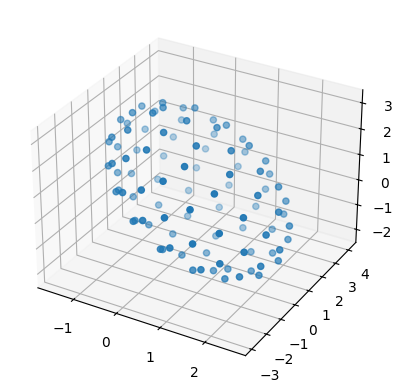

In [15]:
# Plot the obtained states and effects

found_state_space = numerical_result[0]
found_effects_space = numerical_result[0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(found_state_space[:,1], found_state_space[:,2], found_state_space[:,3])
# ax.view_init(0., 0) # point of view
plt.show()

At this point, the state and effect spaces are not normalized. Jump to **Step 3** to see how to normalize them

In [10]:
# (optional) Export the found data to save it
# This cell creates two files 'S_realised1.csv' and 'E_realised1.csv' which contain the states and effects found on the previous cell

data_num = 1 # this is our arbitrary for each experimental data set

# get the found states and effects from the variable containing the linear program results
Sprealised = numerical_result[0]
Eprealised = numerical_result[1]

filename = f'Data/S_realised{data_num}.csv'
filepath = os.path.join(os.getcwd(), filename)

with open(filepath, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(Sprealised) # change name if different in your version project

filename = f'Data/E_realised{data_num}.csv'
filepath = os.path.join(os.getcwd(), filename)

with open(filepath, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(Eprealised) # change name if different in your version project

# Step 2: Which rank $k$ gives the best GPT fit?

Here we find a GPT model of rank $k$ for each rank $k\in \{2,3,\ldots,9\}$. In other words, we compute the maximum-likelihood models fittin the given experimental data for different rank $k$ candidates. Then we plot the errors chi_squared which showcase that indeed rank $4$ gives the best GPT model fit

In [17]:
# the seesaw optimization for a range of different ranks
convergence_tolerance = 1e-07 # we assume convergence when the progress is smaller than convergence_tolerance
first_rank = 2 # inclusive
final_rank = 9 # inclusive
trainmodel_convergence = seesaw_over_range(state_optim, effect_optim_NOAB, datamat, first_rank, final_rank, convergence_tolerance)

Rank = 2, iteration = 1. Current Chi^2 = 658018.5597672632
Rank = 2, iteration = 2. Current Chi^2 = 144419.4138581511
Rank = 2, iteration = 3. Current Chi^2 = 144307.0326015785
Rank = 2, iteration = 4. Current Chi^2 = 144276.70426287106
Rank = 2, iteration = 5. Current Chi^2 = 144249.23031585652
Rank = 2, iteration = 6. Current Chi^2 = 144224.3366663449
Rank = 2, iteration = 7. Current Chi^2 = 144201.78262652663
Rank = 2, iteration = 8. Current Chi^2 = 144181.34817206056
Rank = 2, iteration = 9. Current Chi^2 = 144162.8324062884
Rank = 2, iteration = 10. Current Chi^2 = 144146.05206182454
Rank = 2, iteration = 11. Current Chi^2 = 144130.84006511845
Rank = 2, iteration = 12. Current Chi^2 = 144117.0441960696
Rank = 2, iteration = 13. Current Chi^2 = 144104.5258110892
Rank = 2, iteration = 14. Current Chi^2 = 144093.15864949097
Rank = 2, iteration = 15. Current Chi^2 = 144082.8277562693
Rank = 2, iteration = 16. Current Chi^2 = 144073.4284274819
Rank = 2, iteration = 17. Current Chi^2 = 

Next, we use the trained model fit on both the experimental data used to train it and a new experimental data used as a *test* set to compare the error $\chi^2$ attributed to each

In [24]:
input_values = range(8)

# use the trained model to fit the error on the experimental data set used to train it
train_error = [chisquared(trainmodel_convergence[x], datamat) for x in input_values]
print(train_error)

# use the trained model to fit the error on a new experimental data set used as a test
test_error = [chisquared(trainmodel_convergence[x], testmat) for x in input_values]
print(test_error )

[142826.64617068463, 65440.16208381295, 497.7672881204718, 473.38591246734063, 453.5071680289922, 435.92340313242994, 419.01835288016497, 402.4958899717351]
[147882.61559346772, 68137.31690185667, 1461.83594804813, 1468.8987752329572, 1485.2587186968099, 1499.8483794710646, 1516.0524625101361, 1528.4747061779692]


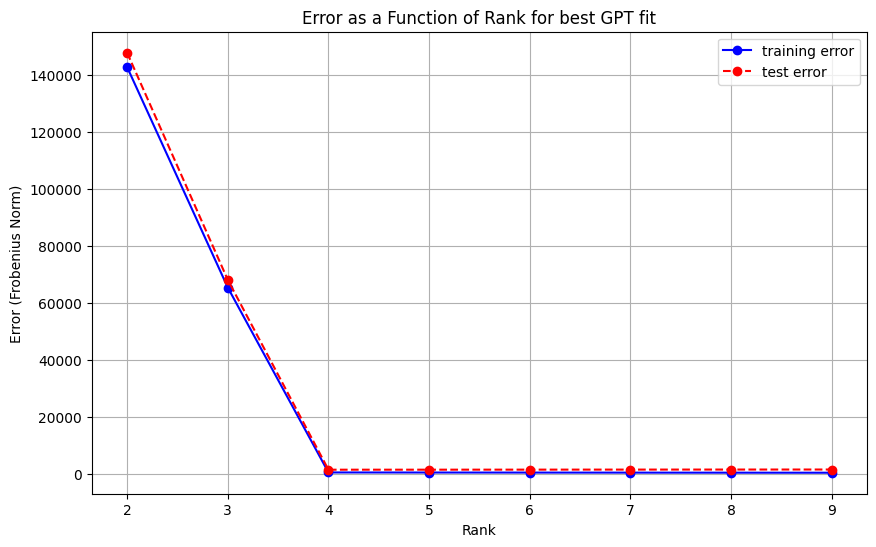

In [19]:
# plot both to visualy compare

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), train_error, marker='o', linestyle='-', color='b',label = 'training error')
plt.plot(range(2, 10), test_error, marker='o', linestyle='--', color='r',label = 'test error')
plt.title('Error as a Function of Rank for best GPT fit')
plt.xlabel('Rank')
plt.ylabel('Error (Frobenius Norm)')
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Use the QR decomposition to encode the normalization of states

Here we transform the obtained states and effects. In paritcular, we start from having pre-computed a GPT model for some $\mathrm{rank} = k$ (e.g., run the cells above in **Step 1** or load data) to get a state space $S$ and effect space $E$. Then, we use the QR decomposition on the data table $D=SE$ to express it such that the first column of $S$ is a column of ones (encoding the normalisation of the states), and the first column of $E$ is the trivial effect $(1,0,...,0)^T$.

In [26]:
# Start by using the previously obtained states and effects to build the frequency table D_realized
# Here we use the data computed in Step 1, stored in the variable numerical_result
Drealized = np.dot(numerical_result[0],numerical_result[1]) # numerical_result[0] are the states, numerical_result[1] are the effects
Drealized = datamat

# obtain QR decomposition of Drealized and scale
Q, R = np.linalg.qr(Drealized)
c = Q[0,0]
Qprime = Q/c
Rprime = c*R

# Partition the Q, R matrices
Q0 = np.array([Qprime[:,0]]).T # my way of making it a column vector (2D-array)
Q1 = np.delete(Qprime, 0, axis=1)

R0 = np.array([Rprime[0,:]])
R1 = np.delete(Rprime, 0, axis=0)

# Singular value decomposition
tmp_matrix = np.dot(Q1,R1)
U, Sigma, V = np.linalg.svd(tmp_matrix)
V = V.T
Sigma = np.diag(Sigma) # making it actually a matrix, instead of the array that builds the diag matrix

# Obtain the normalized Srealized and Erealized
Srealized = np.block([Q0, np.dot(U[:,0:rank-1],np.sqrt(Sigma[0:rank-1,0:rank-1]))])
Erealized = np.block([[R0], [np.dot(np.sqrt(Sigma[0:rank-1,0:rank-1]), V[:,0:rank-1].T)]])

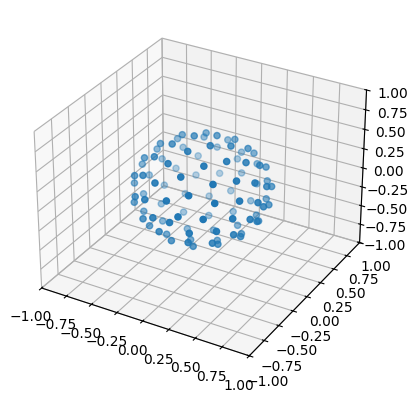

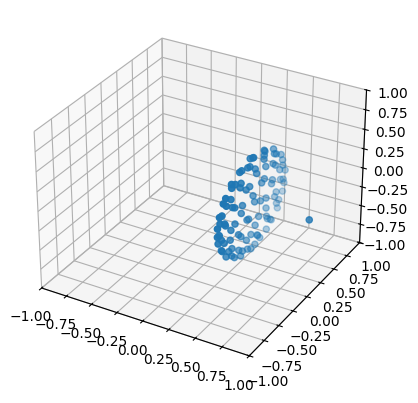

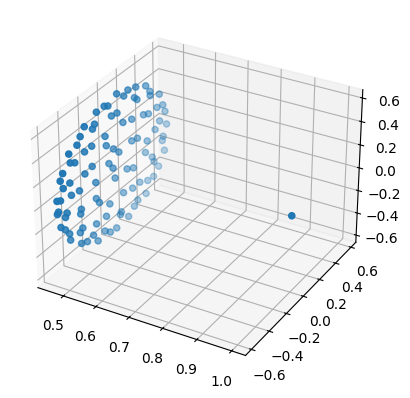

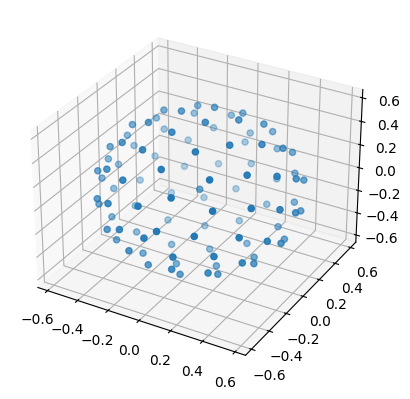

In [27]:
# Visualize the state and effect spaces

# plot the state space (without the column corresponding to ones)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Srealized[:,1], Srealized[:,2], Srealized[:,3])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# ax.view_init(0., 0) # point of view
plt.show()

# plot the 3d projections of the effect space
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Erealized[0,:], Erealized[1,:], Erealized[2,:])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Erealized[0,:], Erealized[1,:], Erealized[3,:])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Erealized[1,:], Erealized[2,:], Erealized[3,:])
plt.show()

# Step 4: Find the consistent spaces by finding dual spaces

## (Optional) How to stack the data frequencies with different time evolution preparations

In [13]:
# We start by loading the data we want to stack (i.e., the frequency tables containing the different time evolution preparations)

data_num = 1 # arbitrary label of the experimental run to load
datafile = f'Data/zzzGPTwait0run{data_num}.csv'
datamat = np.genfromtxt(datafile, delimiter=",")

tau = [5000,10000,15000,20000,30000,40000,50000] # the time evolutions implemented

# stack the experimental data for the different time evolutions
for t in tau:
    datafile = f'Data/zzzGPTwait{t}run{data_num}.csv'
    new = np.genfromtxt(datafile, delimiter=",") 
    datamat = np.vstack((datamat, new))

num_prep = len(datamat)
num_meas = len(datamat.T)

In [14]:
# Get the number of preparations and measurements implemented

matrix_dimensions = datamat.shape # data dimensions
cardinality_preparations = matrix_dimensions[0] # number of preparations
cardinality_measurements = matrix_dimensions[1] # number of measurements

runs_number = 100 # how many runs were used to estimate each conditional probability, to be set manualy
oneoverW = runs_number/np.multiply(datamat, 1-datamat) # 1/W = 1/(\Sum \Delta F_ij)^2, I think (check)
oneoverW = np.array(oneoverW, dtype=np.float32)
#Wprime = np.diag(oneoverW.flatten(('F')))
Wprime = sp.sparse.diags(oneoverW.flatten(('F')), 0, format='csr')
Id_m = np.ones(cardinality_preparations) # for when we do not want these constraints on S and E.
Id_n = np.ones(cardinality_measurements)
Id_m = sp.sparse.diags(Id_m, 0, format='csr')
Id_n = sp.sparse.diags(Id_n, 0, format='csr')

## Main approach

The general idea is that $S_{\textrm{consistent}}$ is the dual space of $E_{\textrm{realized}}$, and $E_{\textrm{consistent}}$ is the dual of $S_{\textrm{realized}}$

First let's define a new function to compute the dual space of a given set in a halfspace form

In [28]:
# Function to obtain the dual space. That is, to get S_consistent and E_consistent
# https://pycddlib.readthedocs.io/en/latest/polyhedron.html

def dual_space(matrix,dim):
    mat = cdd.Matrix(matrix, linear=False, number_type="float") 
    mat.rep_type = cdd.RepType.INEQUALITY
    poly = cdd.Polyhedron(mat)
        
    ext = poly.get_generators()
    #print(ext)
    
    dual_M = np.empty((0, dim))
    for row in ext:
        row = list(row)
        row = row[1:5]
        #print(row)
        dual_M = np.append(dual_M,[row],axis=0)
        
    return dual_M

Next, we load the realized spaces data

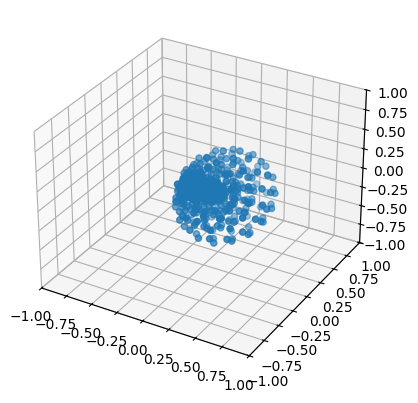

In [32]:
# load S and E realized from pre-computed data

data_num = 1

# load states realised
filename = f'Data/rd_S_realised{data_num}.csv'
filepath = os.path.join(os.getcwd(), filename)

Sprealised = np.genfromtxt(filepath, delimiter=",") 
Srx = Sprealised[:, 1]
Sry = Sprealised[:, 2]
Srz = Sprealised[:, 3]

# load effects realised
filename = f'Data/rd_E_realised{data_num}.csv'
filepath = os.path.join(os.getcwd(), filename)

Eprealised = np.genfromtxt(filepath, delimiter=",") 

# plot to see what we are dealing with
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Sprealised[:,1], Sprealised[:,2], Sprealised[:,3])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# ax.view_init(0., 0) # point of view
plt.show()

In [33]:
# For a polyhedron described as P = {x | A x <= b}, the H-representation is the matrix [b -A].

A = np.vstack((-Eprealised.T,Eprealised.T))
b = np.array([np.zeros(len(Eprealised.T)),np.ones(len(Eprealised.T))]).reshape(2*len(Eprealised.T),1)
A = -np.array(A)
b = np.array(b)
M = np.hstack((b,A))
#print(M)

Spconsistent = dual_space(M,len(Eprealised))

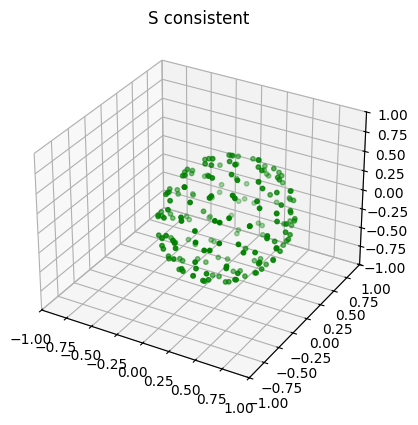

In [35]:
# Visualize the obtained S_consistent

# Extract x,y,z coordinates for visualization purposes
Scx = Spconsistent[:, 1]
Scy = Spconsistent[:, 2]
Scz = Spconsistent[:, 3]

# Plot points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Scx,Scy,Scz, c='g', marker='o',s=10)
plt.title('S consistent')
#ax.view_init(0., 0)
axissize=1
ax.set_xlim([-axissize, axissize])
ax.set_ylim([-axissize, axissize])
ax.set_zlim([-axissize, axissize])
plt.show()

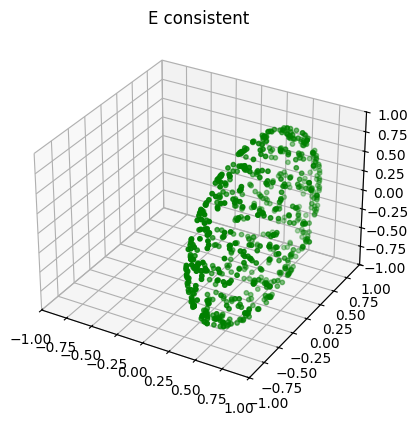

In [36]:
# Same as above but to get E_consistent instead

# compute the dual space, this time of S_realized
C = np.vstack((-Sprealised,Sprealised))
d = np.array([np.zeros(len(Sprealised)),np.ones(len(Sprealised))]).reshape(2*len(Sprealised),1)
C = -np.array(C)
d = np.array(d)
N = np.hstack((d,C))

Epconsistent = dual_space(N,len(Sprealised.T))

# Extract x,y,z coordinates for visualization purposes
Ecx = Epconsistent[:, 0]
Ecy = Epconsistent[:, 2]
Ecz = Epconsistent[:, 3]

# Plot points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Ecx,Ecy,Ecz, c='g', marker='o',s=10)
plt.title('E consistent')
#ax.view_init(0., 90)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
plt.show()

Finally we compare the *realised* and *consistent* sets

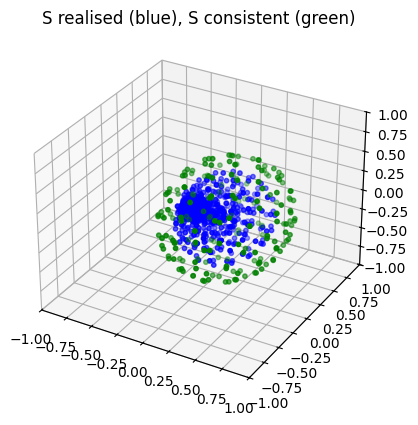

In [40]:
# Plot state spaces
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Srx,Sry,Srz, marker='o',s=10, c='blue')
ax.scatter(Scx,Scy,Scz, marker='o',s=10, c='green')
plt.title('S realised (blue), S consistent (green)')
#ax.view_init(0., 0)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# plt.savefig(f'Src{data_num}.png', format='png')
plt.show()

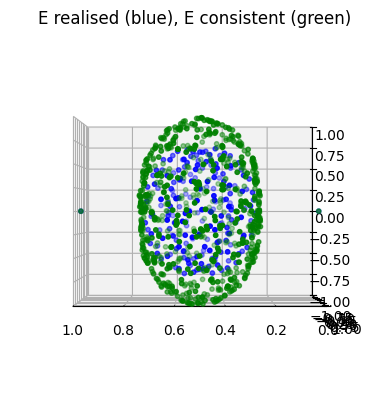

In [38]:
# Plot effect spaces
Erx = Eprealised[0, :]
Ery = Eprealised[2, :]
Erz = Eprealised[3, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Erx,Ery,Erz, marker='o',s=10, c='blue')
ax.scatter(Ecx,Ecy,Ecz, marker='o',s=10, c='green')
plt.title('E realised (blue), E consistent (green)')
#plt.title(f"wait time = {datanum}, run = {data_num}")
ax.view_init(0., 90)
ax.set_xlim([0, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# plt.savefig(f'Erc{data_num}.png', format='png') # to save the figure
plt.show()

# Step 5: Normalize the state spaces with respect to the consistent effect space E_consistent

In order to compare the different state spaces S_realized, it is desirable to have a normalization applied to all sets. The approach we choose is to use the fact that all their effect spaces consistent are, in principle, the same (since the effects applied on the experiment are always the same). Therefore, We use the fact that S_consistent (the dual of E_consistent) should be close to a unit ball in order to find a suitable transformation that brings the found set as close to a unit ball as possible. We then apply this same transformation to all S_realized sets considered. The transformation is split in two steps: first weapply a translation on the set to center it, and second we find a rotation and scale that approximate the states to unit vectors. As a precaution, we also define and run a function to remove all interior points of the given set and use only the boundary points. See text for details

In [41]:
# Here we define the algorithm to find the linear transformation that brings the states as close to a unit sphere as possible
# See text for details

# Euler angles to get a rotation matrix V which is orthogonal and explores all SO(3)
def euler_angles_matrix(alpha, beta, gamma):
    V = [[np.cos(alpha)*np.cos(gamma)-np.sin(alpha)*np.cos(beta)*np.sin(gamma), -np.cos(alpha)*np.sin(gamma)-np.sin(alpha)*np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)],[np.sin(alpha)*np.cos(gamma)+np.cos(alpha)*np.cos(beta)*np.sin(gamma), -np.sin(alpha)*np.sin(gamma)+np.cos(alpha)*np.cos(beta)*np.cos(gamma), -np.cos(alpha)*np.sin(beta)], [np.sin(beta)*np.sin(gamma), np.sin(beta)*np.cos(gamma), np.cos(beta)]];     
    return np.array(V)

# the objective function to approximate the states to a unit vector
def obective_function(variables,data_points):
    data_points = remove_interior_points(data_points) # get boundary points only
    if len(data_points.T)>3:
        data_points = data_points[::,1:4] # keep the 3D subset we are interested in
    data_points = data_points - np.mean(data_points, axis=0) # use the collumn-wise mean to center the cloud of points
    
    # initialize variables
    res = 0
    sigma1 = variables[0]
    sigma2 = variables[1]
    sigma3 = variables[2]
    alpha = variables[3]
    beta = variables[4]
    gamma = variables[5]
    V = euler_angles_matrix(alpha, beta, gamma)
    
    # the actual objective function
    for i in range(0,len(data_points)):
        # broken up in steps to make the objective function more visually appealing
        S_i = data_points[i,::]
        SigmaSquared = np.dot(np.diag([sigma1, sigma2, sigma3]),np.diag([sigma1, sigma2, sigma3]))
        norm_val = np.linalg.norm(np.dot(np.dot(np.dot(np.dot(S_i,V),SigmaSquared),V.T),S_i.T))        
        
        res = res + np.dot(1-np.dot(norm_val,norm_val),1-np.dot(norm_val,norm_val))
    return res

def find_transformation(data_points):
    # using scipy's minimize function:
    x0 = np.ndarray.flatten(np.random.rand(1,6)) # the initial guess is random for now
    linear_constraint = LinearConstraint([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]], [0,0,0,-2*np.pi,-2*np.pi,-2*np.pi], [2,2,2,2*np.pi,2*np.pi,2*np.pi])
    
    res = scipy.optimize.minimize(obective_function, x0, args=(data_points), constraints=[linear_constraint])
    return res

def apply_transformation(data_points,Sigma,V):
# previously need to Apply translation-transform given by the column-wise mean of S_consistent to the data
# data_points = data_points - np.mean(data_points, axis=0) # column-wise mean to center cloud of data points    
    
    n = len(data_points)
    if len(data_points.T)>3: # I don't want the column of ones
        data_points = data_points[::,1:4]
    
    newSconsistent = np.atleast_2d(np.dot(np.dot(Sigma,V.T), data_points[0,::].T)) # Initialize the variable with the first point. s_i' into row vector
    for i in range(1,n): # iterate and append the rest
        S_i = data_points[i,::]
        newSi = np.atleast_2d(np.dot(np.dot(Sigma,V.T), S_i.T)) # s_i' in row form
        newSconsistent = np.vstack((newSconsistent, newSi)) # stack rows on top of each other
    return newSconsistent

In [43]:
# (optional) Remove interior points algorithm 
# This is a precautory step to guarantee that we deal only with the boundary points only

def remove_interior_points(data_points):
    # initialize variables
    current_points = data_points # variable on which to update the set
    index = 0 # dummy variable to count

    # Linear Programming
    # Algorithm sketch: Take all the set of data points except of the row specified by the variable "index". Then check whether one can make a convex combination of the data points to recover the missing one. If it can, then we discard it since it is a mixture of other points in the set and, thus, not a boundary/extremal point.
    while index < len(current_points): # we probe all rows in the set
        # start specifying the linear program conditions
        fun = np.zeros((1, len(current_points)-1)).T # this is to set the objective function to 0 and have a feasibility problem (instead of optimization)
        Aeq = np.delete(current_points, index, 0).T # the data points minus the row being tested. the first row of ones will be used for the convex combination elements
        beq = current_points[index,::].T
        LB = np.zeros(len(current_points.T)) # elements of x should be greater than 0 <= x_i
        UB = np.ones(len(current_points.T)) 

        # compute the linear program
        res = linprog(fun, A_ub=None, b_ub=None, A_eq=Aeq, b_eq=beq, bounds=[(0, None)])
        # if successful we remove the row
        if res.success == True:
            current_points = np.delete(current_points, index, 0)
            index = index - 1
        index = index + 1 # clumsy way of counting. I do not do a For loop because the size of the set changes as the states get deleted
            
    return current_points

First we need the experimental data. In this case, instead of computing and processing it as explained above, we load it from pre-computed data:

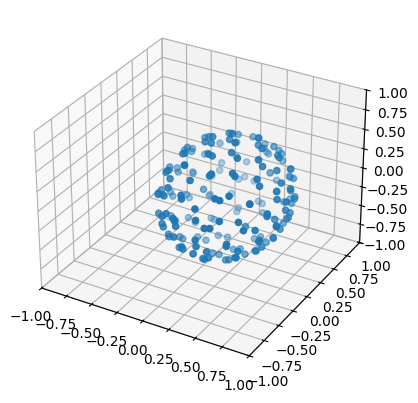

In [44]:
# As an example, load S and E consistent from pre-computed data

data_num = 1 # this is our arbitrary label for the experimental run

# load effects consistent
filename = f'Data/E_consistent{data_num}.csv'
filepath = os.path.join(os.getcwd(), filename)

Econsistent = np.genfromtxt(filepath, delimiter=",") 

# load states consistent
filename = f'Data/S_consistent{data_num}.csv'
filepath = os.path.join(os.getcwd(), filename)

Sconsistent = np.genfromtxt(filepath, delimiter=",") 

# plot for an illustrative visualization
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Sconsistent[:,1], Sconsistent[:,2], Sconsistent[:,3])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# ax.view_init(0., 0) # point of view
plt.show()

We are now ready to find the transformation:

In [45]:
res = find_transformation(Sconsistent)

(res.fun)/len(Sconsistent) # this shows the average distance away from unity that the norm of each state has. The closer to zero the better the approximation to a unit sphere

0.0021633811744230444

In [46]:
# Gather the results for the transformation in variables
variables = res.x
translationSconsistent = np.mean(Sconsistent, axis=0)
Sigma = np.diag([variables[0], variables[1], variables[2]])
alpha = variables[3]
beta = variables[4]
gamma = variables[5]
V = euler_angles_matrix(alpha,beta,gamma)

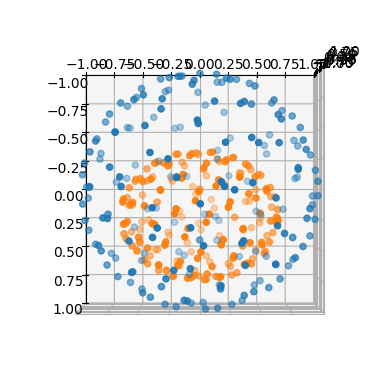

In [47]:
# Apply and plot the obtained transformation to the set S_consistent
SconsistentTransformed = apply_transformation(Sconsistent - translationSconsistent,Sigma,V)

# plot S_consistent before and after the transformation to compare, and to visualize if the transformed resembles a unit sphere as desired
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(SconsistentTransformed[:,0], SconsistentTransformed[:,1], SconsistentTransformed[:,2])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.scatter(Sconsistent[:,1], Sconsistent[:,2], Sconsistent[:,3]) # to compare with the original
ax.view_init(90., 0) # point of view
plt.show()

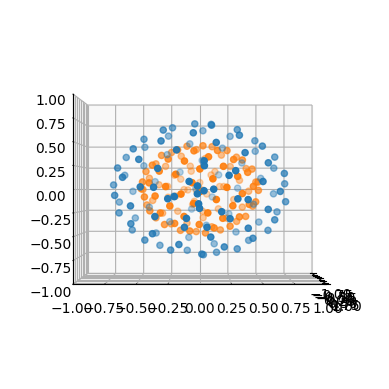

In [48]:
# (illustrativee example) How to apply and plot the previously found transformation to some given S_realized

# load and transform the data, in our case States_realized
data_num = 1
filename = f'Data/rd_S_realised{data_num}.csv'
filepath = os.path.join(os.getcwd(), filename)
Srealised = np.genfromtxt(filepath, delimiter=",") 


SrealisedBoundary = remove_interior_points(Srealised) # (optional) remove the interior points for precaution
SrealisedCentered = SrealisedBoundary - translationSconsistent # center the set w.r.t. S_consistent
SrealisedTransformed = apply_transformation(SrealisedCentered, Sigma, V) # Apply the transformation to the centered set

# plot comparing before and after transforming
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(SrealisedTransformed[:,0], SrealisedTransformed[:,1], SrealisedTransformed[:,2])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.scatter(SrealisedBoundary[:,1], SrealisedBoundary[:,2], SrealisedBoundary[:,3]) # to compare with the original
ax.view_init(0., 0) # point of view
plt.show()

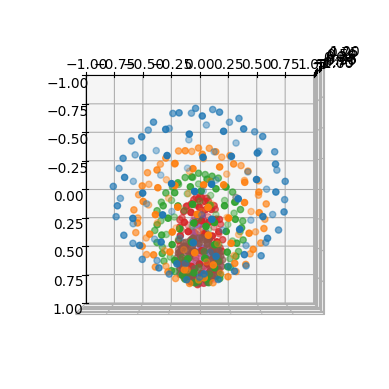

In [49]:
# Iteratively apply and plot the transformation to different S_realized and separately plot the state spaces corresponding to different time evolutions
# as of now you need to have found a transformation in a previous step

# plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
for i in range(1,8):
#    for data_num in range(1,8): # to get the different runs of the same experiment
    data_num = 1 # for lazyness i just check the first run
    # load and transform states_realized
    filename = f'Data/rd_S_realised{data_num}.csv'
    filepath = os.path.join(os.getcwd(), filename)
    Srealised = np.genfromtxt(filepath, delimiter=",") 
    SrealisedBoundary = remove_interior_points(Srealised[(i-1)*100:i*100,::])
    SrealisedTransformed = apply_transformation(SrealisedBoundary - translationSconsistent,Sigma,V)        
    ax.scatter(SrealisedTransformed[:,0], SrealisedTransformed[:,1], SrealisedTransformed[:,2])

ax.view_init(90., 0) # point of view
plt.show()

# Step 6: Compute the volume of the state spaces corresponding to different time evolutions

In [40]:
# It assumes that the normalization transformation has been already computed, otherwise run:

# get transformation to normalize
res = find_transformation(SconsistentBoundary)
variables = res.x
translationSconsistent = np.mean(SconsistentBoundary, axis=0)
Sigma = np.diag([variables[0], variables[1], variables[2]])
alpha = variables[3]
beta = variables[4]
gamma = variables[5]
V = euler_angles_matrix(alpha,beta,gamma)

In [45]:
# Compute the volume of the State Spaces corresponding to different time evolutions Tau to compare
# We use the delaunay triangulation to split the state space polytope into simplices for which we know their volume formula. Then we just add the volumes of all simplices

from scipy.spatial import Delaunay

def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

vol = [[0]*7 for i in range(8)] # initialize the array gathering the volumes, rows are the Tau, columns the experimental run

# compute the vol for subsequent Tau's
Taus = [0, 5000, 10000, 15000, 20000, 30000, 40000, 50000]
for i in range (1,9):
    # load states_realized experimental run j
    for j in range(1,8):
        data_num = j # which experimental run
        filename = f'Data/rd_S_realised{data_num}.csv'
        filepath = os.path.join(os.getcwd(), filename)
        Srealised = np.genfromtxt(filepath, delimiter=",")  
        SrealisedTau = apply_transformation(Srealised[(i-1)*100:i*100,::] - translationSconsistent,Sigma,V) # the 100 preparations for Tau
        # SrealisedTau = Srealised[(i-1)*100:i*100,1:4] # without transform
        
        dt = Delaunay(SrealisedTau)
        tets = dt.points[dt.simplices]
        vol[i-1][j-1] = np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1], tets[:, 2], tets[:, 3]))
        print ("Tau = " + str(Taus[i-1]) + "; Exp. Run = " + str(j) + "; Volume = " + str(vol[i-1][j-1]))

mean_volumes = np.mean(vol, axis=1)
std_deviations_volums = [np.std(vol[::][i]) for i in range(8)]

Tau = 0; Exp. Run = 1; Volume = 1.539365571574975
Tau = 0; Exp. Run = 2; Volume = 1.6406844785155226
Tau = 0; Exp. Run = 3; Volume = 1.6278747713103507
Tau = 0; Exp. Run = 4; Volume = 1.6282581528387046
Tau = 0; Exp. Run = 5; Volume = 1.6201060891510504
Tau = 0; Exp. Run = 6; Volume = 1.6304919110376348
Tau = 0; Exp. Run = 7; Volume = 1.6468798683753583
Tau = 5000; Exp. Run = 1; Volume = 0.7249997215843613
Tau = 5000; Exp. Run = 2; Volume = 0.6745973917865566
Tau = 5000; Exp. Run = 3; Volume = 0.7168083089365651
Tau = 5000; Exp. Run = 4; Volume = 0.7099014142701736
Tau = 5000; Exp. Run = 5; Volume = 0.7254244483302874
Tau = 5000; Exp. Run = 6; Volume = 0.7109695536748145
Tau = 5000; Exp. Run = 7; Volume = 0.6726099870760465
Tau = 10000; Exp. Run = 1; Volume = 0.2550081680816393
Tau = 10000; Exp. Run = 2; Volume = 0.21024418191055497
Tau = 10000; Exp. Run = 3; Volume = 0.22393960715020864
Tau = 10000; Exp. Run = 4; Volume = 0.21943095469693588
Tau = 10000; Exp. Run = 5; Volume = 0.21392

In [46]:
# Show the mean of the volumes obtained from all the runs and their standard deviation

print(mean_volumes)
print(std_deviations_volums)

[1.61909441 0.7050444  0.22188926 0.03743007 0.00609773 0.03121084
 0.01640127 0.0023584 ]
[0.03356623704259797, 0.020666260521196238, 0.014353650392367613, 0.005782384187403145, 0.002769598336185512, 0.0023652597611755082, 0.0011717821334650221, 0.0002855611853067316]
